In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_u(x, t):
    return torch.sin(x)*torch.cos(t)

def initial_condition_u(x):
    return torch.sin(x) 

In [3]:
# Define the exact solution p = E
def exact_solution_p(x, t):
    return -torch.sin(t)*torch.cos(x)

def initial_condition_p(x):
    return 0.0*torch.sin(x) 

In [4]:
n_data = 250
n_var = 2

data_inp1 = torch.zeros((n_data, n_var))
data_inp1[:, 0] = pi/4
data_inp1[:, 1] = torch.rand((n_data,1)).reshape(-1,)

data_inp2 = torch.zeros((n_data, n_var))
data_inp2[:, 0] = pi/2
data_inp2[:, 1] = data_inp1[:, 1]

data_inp3 = torch.zeros((n_data, n_var))
data_inp3[:, 0] = 3*pi/4
data_inp3[:, 1] = data_inp1[:, 1]

In [5]:
u_data1 = exact_solution_u(data_inp1[:, 0], data_inp1[:, 1])
u_data1 = u_data1.reshape(-1,1)

u_data2 = exact_solution_u(data_inp2[:, 0], data_inp2[:, 1])
u_data2 = u_data2.reshape(-1,1)

u_data3 = exact_solution_u(data_inp3[:, 0], data_inp3[:, 1])
u_data3 = u_data3.reshape(-1,1)

In [6]:
# assigning number of points
initial_pts = 200
left_boundary_pts = 200
right_boundary_pts = 200
residual_pts = 1000

In [7]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
w_init = torch.cat([u_init, p_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
p_b_l = exact_solution_p(xb_left, tb_left)
w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
p_b_r = exact_solution_p(xb_right, tb_right)
w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right), batch_size=200, shuffle=False)

In [8]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [9]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1]+1, n_hidden_layers=4, neurons=20)


In [10]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [11]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [12]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:,0].reshape(-1,1)
                p_hat = w_hat[:,1].reshape(-1,1)
                func = w_hat[:, 2].reshape(-1,1)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
               
                
                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_x = grad_p_hat[:, 0].reshape(-1,1)
                
              
               
                
                
                #grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                #u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1,1)
                
               
                
                p_t = grad_p_hat[:,1].reshape(-1,1)
                
                
                output_data_pred1_ = model(data_inp1)
                u_data_pred1_ = output_data_pred1_[:, 0]
                
                output_data_pred2_ = model(data_inp2)
                u_data_pred2_ = output_data_pred2_[:, 0]
                
                output_data_pred3_ = model(data_inp3)
                u_data_pred3_ = output_data_pred3_[:, 0]
                
                
                
                # Item 1. below
                loss1 = torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + 0.01*torch.mean((u_t.reshape(-1, ) + p_x.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((2*p_t.reshape(-1, )  + func.reshape(-1, ) + u_x.reshape(-1, ) + torch.cos(interior[:, 0])*torch.cos(interior[:, 1])-torch.sin(interior[:, 0]))**p)+torch.mean((p_bd_left_pred_.reshape(-1,) - p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
                data = torch.mean((u_data_pred1_.reshape(-1, ) - u_data1.reshape(-1, ))**p) + torch.mean((u_data_pred2_.reshape(-1, ) - u_data2.reshape(-1, ))**p) + torch.mean((u_data_pred3_.reshape(-1, ) - u_data3.reshape(-1, ))**p)
                loss = loss1 + loss2 + data
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [13]:
n_epochs = 2500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  9.674692153930664
################################  1  ################################
Loss:  9.429093360900879
################################  2  ################################
Loss:  8.021378517150879
################################  3  ################################
Loss:  6.73105525970459
################################  4  ################################
Loss:  5.671327114105225
################################  5  ################################
Loss:  4.801180839538574
################################  6  ################################
Loss:  4.075927257537842
################################  7  ################################
Loss:  3.456829786300659
################################  8  ################################
Loss:  2.93062162399292
################################  9  ################################
Loss:  2.479541301727295
################################  10  ##############

Loss:  0.011550947092473507
################################  93  ################################
Loss:  0.011234425008296967
################################  94  ################################
Loss:  0.01094596553593874
################################  95  ################################
Loss:  0.010655401274561882
################################  96  ################################
Loss:  0.010380635969340801
################################  97  ################################
Loss:  0.010098421014845371
################################  98  ################################
Loss:  0.009809855371713638
################################  99  ################################
Loss:  0.009536374360322952
################################  100  ################################
Loss:  0.009279211051762104
################################  101  ################################
Loss:  0.009044422768056393
################################  102  ################################
Loss:  0

Loss:  0.0023540162947028875
################################  176  ################################
Loss:  0.002327462425455451
################################  177  ################################
Loss:  0.002301202854141593
################################  178  ################################
Loss:  0.002274884609505534
################################  179  ################################
Loss:  0.00224878778681159
################################  180  ################################
Loss:  0.0022226024884730577
################################  181  ################################
Loss:  0.0021965238265693188
################################  182  ################################
Loss:  0.0021704118698835373
################################  183  ################################
Loss:  0.0021443322766572237
################################  184  ################################
Loss:  0.0021190319675952196
################################  185  ############################

Loss:  0.0007952405139803886
################################  265  ################################
Loss:  0.0007899361662566662
################################  266  ################################
Loss:  0.0007846154039725661
################################  267  ################################
Loss:  0.0007796211866661906
################################  268  ################################
Loss:  0.0007746239425614476
################################  269  ################################
Loss:  0.0007697130204178393
################################  270  ################################
Loss:  0.0007650237530469894
################################  271  ################################
Loss:  0.0007605226710438728
################################  272  ################################
Loss:  0.0007560728117823601
################################  273  ################################
Loss:  0.0007516909972764552
################################  274  #######################

Loss:  0.00045834394404664636
################################  355  ################################
Loss:  0.00045598737779073417
################################  356  ################################
Loss:  0.000453702436061576
################################  357  ################################
Loss:  0.0004514247120823711
################################  358  ################################
Loss:  0.0004493090382311493
################################  359  ################################
Loss:  0.0004471761640161276
################################  360  ################################
Loss:  0.00044506503036245704
################################  361  ################################
Loss:  0.00044282563612796366
################################  362  ################################
Loss:  0.00044017552863806486
################################  363  ################################
Loss:  0.0004378309822641313
################################  364  ###################

Loss:  0.00021247293625492603
################################  443  ################################
Loss:  0.0002108702901750803
################################  444  ################################
Loss:  0.00020933145424351096
################################  445  ################################
Loss:  0.00020772815332747996
################################  446  ################################
Loss:  0.0002062087005469948
################################  447  ################################
Loss:  0.00020467471040319651
################################  448  ################################
Loss:  0.0002031710755545646
################################  449  ################################
Loss:  0.00020165265596006066
################################  450  ################################
Loss:  0.00020017199858557433
################################  451  ################################
Loss:  0.00019872108532581478
################################  452  ################

Loss:  0.00012403464643284678
################################  533  ################################
Loss:  0.00012312419130466878
################################  534  ################################
Loss:  0.00012221814540680498
################################  535  ################################
Loss:  0.00012134300777688622
################################  536  ################################
Loss:  0.0001204753716592677
################################  537  ################################
Loss:  0.00011964682198595256
################################  538  ################################
Loss:  0.00011881456157425418
################################  539  ################################
Loss:  0.00011800236825365573
################################  540  ################################
Loss:  0.00011717680172296241
################################  541  ################################
Loss:  0.00011633249232545495
################################  542  ##############

Loss:  5.87431677558925e-05
################################  623  ################################
Loss:  5.849024455528706e-05
################################  624  ################################
Loss:  5.820786827825941e-05
################################  625  ################################
Loss:  5.791969670099206e-05
################################  626  ################################
Loss:  5.76182319491636e-05
################################  627  ################################
Loss:  5.730303382733837e-05
################################  628  ################################
Loss:  5.698367385775782e-05
################################  629  ################################
Loss:  5.6669217883609235e-05
################################  630  ################################
Loss:  5.633175896946341e-05
################################  631  ################################
Loss:  5.5991768022067845e-05
################################  632  #######################

Loss:  3.868432395393029e-05
################################  714  ################################
Loss:  3.857308911392465e-05
################################  715  ################################
Loss:  3.846814433927648e-05
################################  716  ################################
Loss:  3.83627884730231e-05
################################  717  ################################
Loss:  3.8266414776444435e-05
################################  718  ################################
Loss:  3.8166530430316925e-05
################################  719  ################################
Loss:  3.806103268289007e-05
################################  720  ################################
Loss:  3.79477787646465e-05
################################  721  ################################
Loss:  3.782669591601007e-05
################################  722  ################################
Loss:  3.769309842027724e-05
################################  723  #######################

Loss:  2.71499011432752e-05
################################  804  ################################
Loss:  2.705936276470311e-05
################################  805  ################################
Loss:  2.6964204153046012e-05
################################  806  ################################
Loss:  2.687311098270584e-05
################################  807  ################################
Loss:  2.6787456590682268e-05
################################  808  ################################
Loss:  2.670438880159054e-05
################################  809  ################################
Loss:  2.663027225935366e-05
################################  810  ################################
Loss:  2.655355456226971e-05
################################  811  ################################
Loss:  2.6487923605600372e-05
################################  812  ################################
Loss:  2.6428033379488625e-05
################################  813  ####################

Loss:  2.205238888564054e-05
################################  891  ################################
Loss:  2.2014810383552685e-05
################################  892  ################################
Loss:  2.198354013671633e-05
################################  893  ################################
Loss:  2.1954559997539036e-05
################################  894  ################################
Loss:  2.1921774532529525e-05
################################  895  ################################
Loss:  2.189391670981422e-05
################################  896  ################################
Loss:  2.1860121705685742e-05
################################  897  ################################
Loss:  2.1822750568389893e-05
################################  898  ################################
Loss:  2.1776002540718764e-05
################################  899  ################################
Loss:  2.1722042220062576e-05
################################  900  ################

Loss:  1.7159673006972298e-05
################################  981  ################################
Loss:  1.7124604710261337e-05
################################  982  ################################
Loss:  1.7090083929360844e-05
################################  983  ################################
Loss:  1.7056678188964725e-05
################################  984  ################################
Loss:  1.702451663732063e-05
################################  985  ################################
Loss:  1.6993313693092205e-05
################################  986  ################################
Loss:  1.696354775049258e-05
################################  987  ################################
Loss:  1.6934509403654374e-05
################################  988  ################################
Loss:  1.690655517450068e-05
################################  989  ################################
Loss:  1.6879102986422367e-05
################################  990  ################

Loss:  1.5372856069006957e-05
################################  1071  ################################
Loss:  1.5349862223956734e-05
################################  1072  ################################
Loss:  1.533102840767242e-05
################################  1073  ################################
Loss:  1.5309648006223142e-05
################################  1074  ################################
Loss:  1.5291232557501644e-05
################################  1075  ################################
Loss:  1.527085987618193e-05
################################  1076  ################################
Loss:  1.5250241631292738e-05
################################  1077  ################################
Loss:  1.5228693882818334e-05
################################  1078  ################################
Loss:  1.5206169337034225e-05
################################  1079  ################################
Loss:  1.517607415735256e-05
################################  1080  ######

Loss:  1.2806456652469933e-05
################################  1161  ################################
Loss:  1.2787792002200149e-05
################################  1162  ################################
Loss:  1.2767977750627324e-05
################################  1163  ################################
Loss:  1.2750862879329361e-05
################################  1164  ################################
Loss:  1.2733991752611473e-05
################################  1165  ################################
Loss:  1.2716569472104311e-05
################################  1166  ################################
Loss:  1.2699469152721576e-05
################################  1167  ################################
Loss:  1.268354753847234e-05
################################  1168  ################################
Loss:  1.2667748706007842e-05
################################  1169  ################################
Loss:  1.2652957593672909e-05
################################  1170  ####

Loss:  1.1235297279199585e-05
################################  1248  ################################
Loss:  1.1210607226530556e-05
################################  1249  ################################
Loss:  1.1185166840732563e-05
################################  1250  ################################
Loss:  1.1160123904119246e-05
################################  1251  ################################
Loss:  1.1135195563838352e-05
################################  1252  ################################
Loss:  1.1111005733255297e-05
################################  1253  ################################
Loss:  1.1087236998719163e-05
################################  1254  ################################
Loss:  1.1060505130444653e-05
################################  1255  ################################
Loss:  1.1043131962651387e-05
################################  1256  ################################
Loss:  1.1025011190213263e-05
################################  1257  ###

Loss:  1.0251126695948187e-05
################################  1338  ################################
Loss:  1.0239946277579293e-05
################################  1339  ################################
Loss:  1.0228810424450785e-05
################################  1340  ################################
Loss:  1.0217708222626243e-05
################################  1341  ################################
Loss:  1.020671334117651e-05
################################  1342  ################################
Loss:  1.0195360118814278e-05
################################  1343  ################################
Loss:  1.0185072824242525e-05
################################  1344  ################################
Loss:  1.017246086121304e-05
################################  1345  ################################
Loss:  1.0158436452911701e-05
################################  1346  ################################
Loss:  1.014521603792673e-05
################################  1347  ######

Loss:  9.18350815481972e-06
################################  1425  ################################
Loss:  9.167247299046721e-06
################################  1426  ################################
Loss:  9.150052392215002e-06
################################  1427  ################################
Loss:  9.130355465458706e-06
################################  1428  ################################
Loss:  9.11133611225523e-06
################################  1429  ################################
Loss:  9.088480510399677e-06
################################  1430  ################################
Loss:  9.072832654055674e-06
################################  1431  ################################
Loss:  9.05644628801383e-06
################################  1432  ################################
Loss:  9.038398275151849e-06
################################  1433  ################################
Loss:  9.019422577694058e-06
################################  1434  ################

Loss:  8.288888238894287e-06
################################  1515  ################################
Loss:  8.282052476715762e-06
################################  1516  ################################
Loss:  8.274944775621407e-06
################################  1517  ################################
Loss:  8.26672840048559e-06
################################  1518  ################################
Loss:  8.258499292423949e-06
################################  1519  ################################
Loss:  8.250849532487337e-06
################################  1520  ################################
Loss:  8.243358024628833e-06
################################  1521  ################################
Loss:  8.235855602833908e-06
################################  1522  ################################
Loss:  8.228550541389268e-06
################################  1523  ################################
Loss:  8.221366442739964e-06
################################  1524  ##############

Loss:  7.432650818373077e-06
################################  1605  ################################
Loss:  7.420808742608642e-06
################################  1606  ################################
Loss:  7.408311830658931e-06
################################  1607  ################################
Loss:  7.395236934826244e-06
################################  1608  ################################
Loss:  7.383456249954179e-06
################################  1609  ################################
Loss:  7.372621439571958e-06
################################  1610  ################################
Loss:  7.360409199463902e-06
################################  1611  ################################
Loss:  7.350203304667957e-06
################################  1612  ################################
Loss:  7.338850082305726e-06
################################  1613  ################################
Loss:  7.3262172008981e-06
################################  1614  ###############

Loss:  6.522149305965286e-06
################################  1692  ################################
Loss:  6.517334895761451e-06
################################  1693  ################################
Loss:  6.513673724839464e-06
################################  1694  ################################
Loss:  6.508681508421432e-06
################################  1695  ################################
Loss:  6.504641532956157e-06
################################  1696  ################################
Loss:  6.499422852357384e-06
################################  1697  ################################
Loss:  6.495549769169884e-06
################################  1698  ################################
Loss:  6.491571184596978e-06
################################  1699  ################################
Loss:  6.4871237555053085e-06
################################  1700  ################################
Loss:  6.482039680122398e-06
################################  1701  ############

Loss:  5.848453838552814e-06
################################  1782  ################################
Loss:  5.840518042532494e-06
################################  1783  ################################
Loss:  5.833700924995355e-06
################################  1784  ################################
Loss:  5.8259020079276524e-06
################################  1785  ################################
Loss:  5.817949841002701e-06
################################  1786  ################################
Loss:  5.809790309285745e-06
################################  1787  ################################
Loss:  5.800663075206103e-06
################################  1788  ################################
Loss:  5.79234074393753e-06
################################  1789  ################################
Loss:  5.784089353255695e-06
################################  1790  ################################
Loss:  5.774934834334999e-06
################################  1791  #############

Loss:  5.068366590421647e-06
################################  1872  ################################
Loss:  5.060115199739812e-06
################################  1873  ################################
Loss:  5.05271191286738e-06
################################  1874  ################################
Loss:  5.045626949140569e-06
################################  1875  ################################
Loss:  5.038369181420421e-06
################################  1876  ################################
Loss:  5.030476131651085e-06
################################  1877  ################################
Loss:  5.02384591527516e-06
################################  1878  ################################
Loss:  5.017957846575882e-06
################################  1879  ################################
Loss:  5.011288521927781e-06
################################  1880  ################################
Loss:  5.004491868021432e-06
################################  1881  ###############

Loss:  4.566278221318498e-06
################################  1963  ################################
Loss:  4.558268301479984e-06
################################  1964  ################################
Loss:  4.549284767563222e-06
################################  1965  ################################
Loss:  4.541270300251199e-06
################################  1966  ################################
Loss:  4.5324441089178436e-06
################################  1967  ################################
Loss:  4.5235842662805226e-06
################################  1968  ################################
Loss:  4.512862687988672e-06
################################  1969  ################################
Loss:  4.502065621636575e-06
################################  1970  ################################
Loss:  4.492837433645036e-06
################################  1971  ################################
Loss:  4.4828784666606225e-06
################################  1972  ##########

Loss:  4.230740159982815e-06
################################  2051  ################################
Loss:  4.2307237890781835e-06
################################  2052  ################################
Loss:  4.230626473145094e-06
################################  2053  ################################
Loss:  4.230571903462987e-06
################################  2054  ################################
Loss:  4.230434115015669e-06
################################  2055  ################################
Loss:  4.230356353218667e-06
################################  2056  ################################
Loss:  4.230350441503106e-06
################################  2057  ################################
Loss:  4.230213107803138e-06
################################  2058  ################################
Loss:  4.230089871271048e-06
################################  2059  ################################
Loss:  4.230067588650854e-06
################################  2060  ############

Loss:  4.2237861634930596e-06
################################  2141  ################################
Loss:  4.223688392812619e-06
################################  2142  ################################
Loss:  4.223721134621883e-06
################################  2143  ################################
Loss:  4.2236902118020225e-06
################################  2144  ################################
Loss:  4.223513769829879e-06
################################  2145  ################################
Loss:  4.223485120746773e-06
################################  2146  ################################
Loss:  4.223413270665333e-06
################################  2147  ################################
Loss:  4.223363703204086e-06
################################  2148  ################################
Loss:  4.223322775942506e-06
################################  2149  ################################
Loss:  4.223335508868331e-06
################################  2150  ###########

Loss:  4.218488356855232e-06
################################  2231  ################################
Loss:  4.218409685563529e-06
################################  2232  ################################
Loss:  4.218397862132406e-06
################################  2233  ################################
Loss:  4.21824097429635e-06
################################  2234  ################################
Loss:  4.218241429043701e-06
################################  2235  ################################
Loss:  4.218205958750332e-06
################################  2236  ################################
Loss:  4.218137291900348e-06
################################  2237  ################################
Loss:  4.218150024826173e-06
################################  2238  ################################
Loss:  4.2181391108897515e-06
################################  2239  ################################
Loss:  4.2180308810202405e-06
################################  2240  ############

Loss:  4.214178716210881e-06
################################  2321  ################################
Loss:  4.214078671793686e-06
################################  2322  ################################
Loss:  4.214110049360897e-06
################################  2323  ################################
Loss:  4.214040018268861e-06
################################  2324  ################################
Loss:  4.2139936340390705e-06
################################  2325  ################################
Loss:  4.213912689010613e-06
################################  2326  ################################
Loss:  4.213881766190752e-06
################################  2327  ################################
Loss:  4.213725787849398e-06
################################  2328  ################################
Loss:  4.213718057144433e-06
################################  2329  ################################
Loss:  4.213671672914643e-06
################################  2330  ############

Loss:  4.210291990602855e-06
################################  2414  ################################
Loss:  4.2103124542336445e-06
################################  2415  ################################
Loss:  4.210143288219115e-06
################################  2416  ################################
Loss:  4.21008462581085e-06
################################  2417  ################################
Loss:  4.210117367620114e-06
################################  2418  ################################
Loss:  4.210072802379727e-06
################################  2419  ################################
Loss:  4.210027327644639e-06
################################  2420  ################################
Loss:  4.2099682104890235e-06
################################  2421  ################################
Loss:  4.209972757962532e-06
################################  2422  ################################
Loss:  4.209890903439373e-06
################################  2423  ############

In [14]:
# saving and loading Model
FILE = "maxwell1D_3_inverse.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [15]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [16]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = 0.5*torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)


func_test_pred = w_test_pred[:,2].reshape(-1,1)
func_exact = torch.sin(x_test).reshape(-1, 1)

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((func_test_pred - func_exact)**2)/torch.mean(func_exact**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.04961571539752185 %


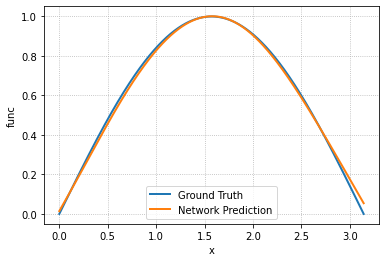

In [18]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, func_exact, label="Ground Truth",lw=2)
plt.plot(x_test, func_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("func")
plt.legend()

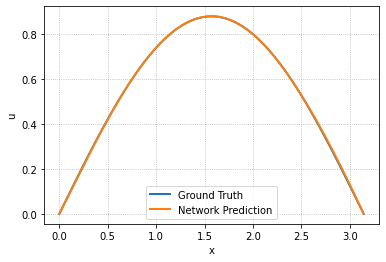

In [19]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [20]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.001339351547358092 %


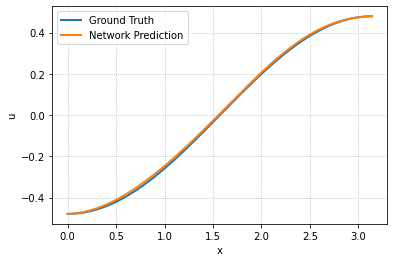

In [21]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [22]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.05279720644466579 %


In [23]:
def exact_solution_D(x, t):
    return -2*torch.sin(t)*torch.cos(x) + torch.sin(x)

In [24]:
# for ploting

In [25]:
model = my_network

x_test = pi*torch.rand(100000)
x_test = x_test.reshape(-1,1)
t_test = 0.5*torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)

u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
f_test = torch.cos(x_test)*torch.cos(t_test)
f_test = f_test.reshape(-1,1)

u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)
p_pred = u_test_pred[:, 1].reshape(-1,1)
func_test_pred = u_test_pred[:, 2].reshape(-1,1)

d_test = exact_solution_D(x_test, t_test).reshape(-1,1)
d_test_pred = 2*p_pred + func_test_pred

relative_error_u = torch.abs(u_pred- u_test)
relative_error_p = torch.abs(p_pred- p_test)
relative_error_f = torch.abs(func_test_pred- f_test)
relative_error_d = torch.abs(d_test_pred- d_test)

x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
u_pred = u_pred.detach().numpy()
p_pred = p_pred.detach().numpy()
func_test_pred = func_test_pred.detach().numpy()
d_test_pred = d_test_pred.detach().numpy()

relative_error_u = relative_error_u.detach().numpy()
relative_error_p = relative_error_p.detach().numpy()
relative_error_f = relative_error_f.detach().numpy()
relative_error_d = relative_error_d.detach().numpy()

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)
func_test_pred = func_test_pred.reshape(-1,)

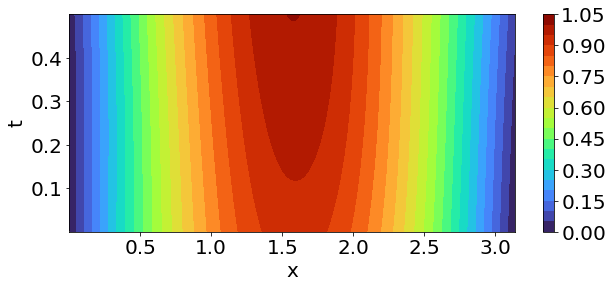

In [26]:
plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, func_test_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('Results/oned/exp3/f_pred.png', dpi = 300, bbox_inches = "tight")

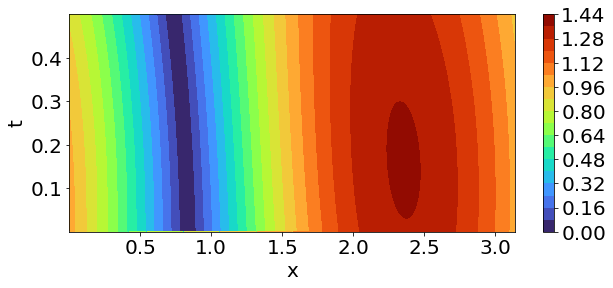

In [27]:
plt.rcParams['figure.figsize'] = [10, 4]
relative_error_f = relative_error_f.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error_f, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('Results/oned/exp3/f_error.png', dpi = 300, bbox_inches = "tight")

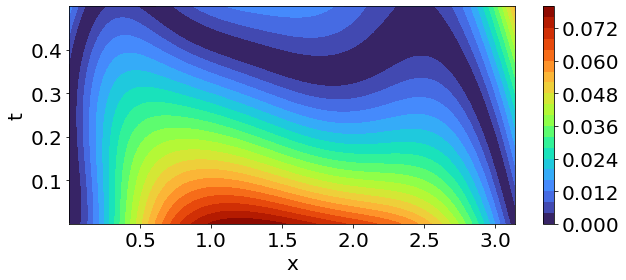

In [28]:
x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error_d = relative_error_d.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error_d, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Results/oned/exp3/relative_error_D.png', dpi = 300, bbox_inches = "tight")

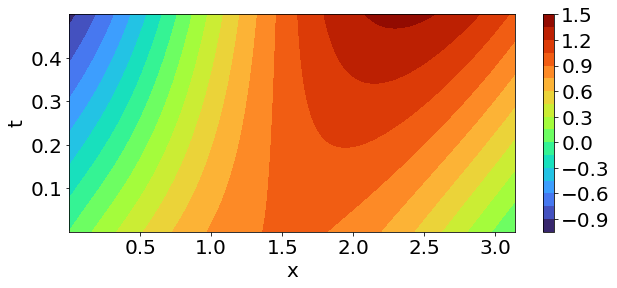

In [29]:
x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
d_test_pred = d_test_pred.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, d_test_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Results/oned/exp3/D_pred.png', dpi = 300, bbox_inches = "tight")

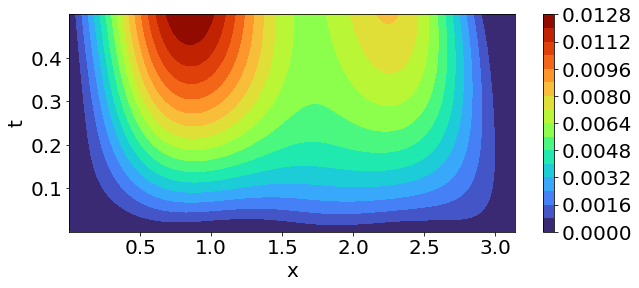

In [30]:
relative_error_p = relative_error_p.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error_p, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Results/oned/exp3/relative_error_E.png', dpi = 300, bbox_inches = "tight")